# Convnet의 학습 시각화하기
convnet의 표현은 시각적인 개념을 학습한 것이기 때문에 시각화할 수 있다!

## Convnet 시각화 기법 개요
#### 1. Convnet **중간 층의 출력**을 시각화
* 연속된 컨브넷 층이 입력을 어떻게 변형시킬까?
* 개별적인 컨브넷 필터의 의미 파악하기

#### 2. Convnet **필터** 시각화
* 컨브넷 필터가 찾으려는 시각적인 패턴와 개념을 이해하기

#### 3. 클래스 활성화에 대한 **heatmap**을 이미지에 시각화
* 이미지의 어떤 부분이 주어진 클래스에 속하는 데 기여했을까?
* 이미지에서 객체 위치를 추정(localization)하기
---

## 1. 중간 층의 활성화 시각화하기
어떤 입력이 주어졌을 때 네트워크에 있는 여러 합성곱과 풀링 층이 출력하는 특성 맵 그리기\
네트워크에 의해 학습된 필터들이 **어떻게 입력을 분해하는지 보여줌**

### pretrained_convnet에서 저장한 모델 load

In [1]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Metal device set to: Apple M1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoo

2022-03-23 01:24:43.228628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-23 01:24:43.228865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 개별 이미지 전처리
네트워크를 훈련할 때 사용했던 이미지에 포함되지 않은 고양이 사진 하나를 입력 이미지로 선택하기:

In [2]:

img_path = '../datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

# 이미지를 4D 텐서로 변경
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# 모델이 훈련될 때 입력에 적용한 전처리 방식을 동일하게 사용
img_tensor /= 255.

# 이미지 텐서 크기: (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


테스트 사진 출력:

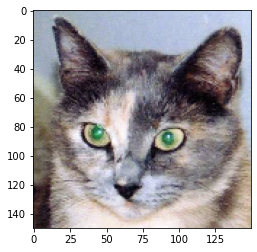

In [3]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

### 케라스의 **Model** 클래스를 사용하여 모델 객체 만들기
확인하고싶은 특성 맵 추출을 위해 이미지 배치를 입력으로 받아 모든 합성곱과 풀링 층의 활성화를 출력하는 케라스 모델 만들기

#### 매개변수
* 입력 텐서(or 입력 텐서의 리스트)
* 출력 텐서(or 출력 텐서의 리스트)

#### 반환되는 객체:
* 특정 입력과 특정 출력을 매핑하는 케라스 모델
* Sequential과 달리 **여러 개의 출력**을 가진 모델 만들 수 있다!(다중출력모델)

In [5]:
from keras import models
# 상위 8개 층의 출력 추출하기
layer_outputs = [layer.output for layer in model.layers[:8]]
# 입력에 대해 8개 층의 출력을 반환하는 모델 만들기
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

입력 이미지가 주어지면 원본 모델의 **활성화 값을 반환**하는 모델\
하나의 입력과 층의 활성화마다 1개씩,, 총 8개의 출력 가짐

### 예측 모드로 모델 실행
층의 활성화마다 1개씩,, 8개의 numpy 배열 리스트 반환!

In [6]:
activations = activation_model.predict(img_tensor)

2022-03-23 10:59:01.193430: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-23 10:59:01.246992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


첫번째 합성곱 층의 활성화 값:

In [7]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


첫번째 활성화 층 중 20번째, 16번째 채널 시각화하기:

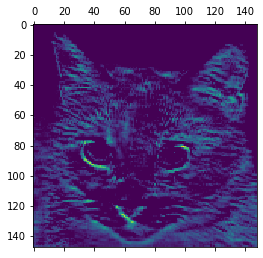

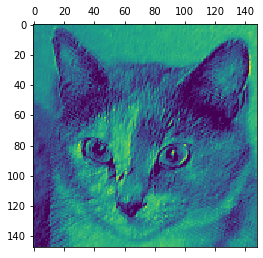

In [27]:
plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.matshow(first_layer_activation[0, :, :, 16], cmap='viridis')
plt.show()

### 네트워크 중간층의 모든 활성화 채널 시각화하기
모든 채널을 그리기 위해 하나의 큰 이미지 텐서에 추출한 결과를 쌓자!

/var/folders/9_/z_nr8_hd32x51b1zx2flsn080000gn/T/ipykernel_20245/984737927.py:29: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std() # 표준편차로 나누기


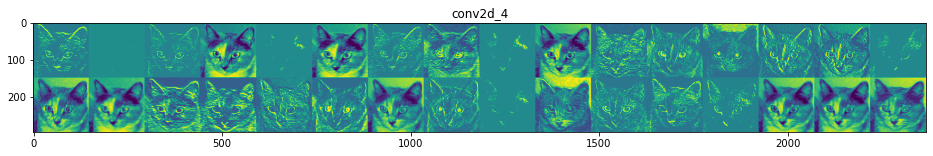

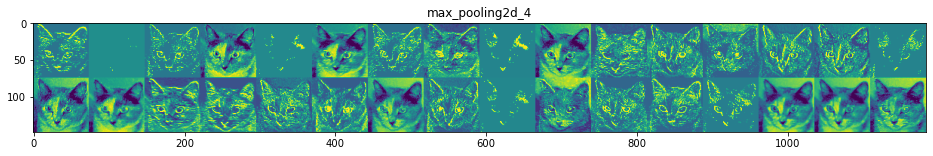

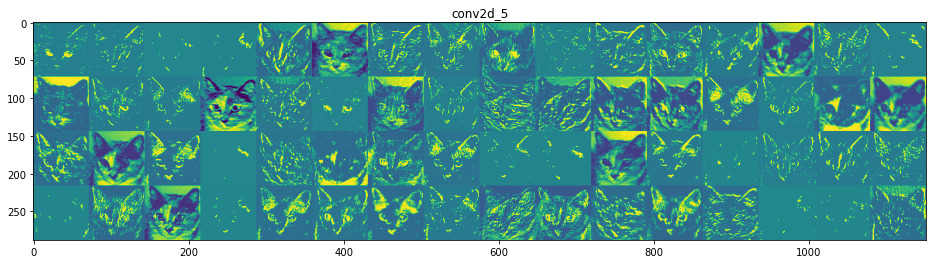

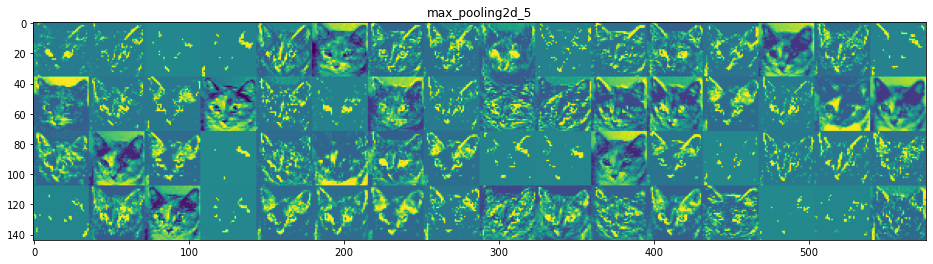

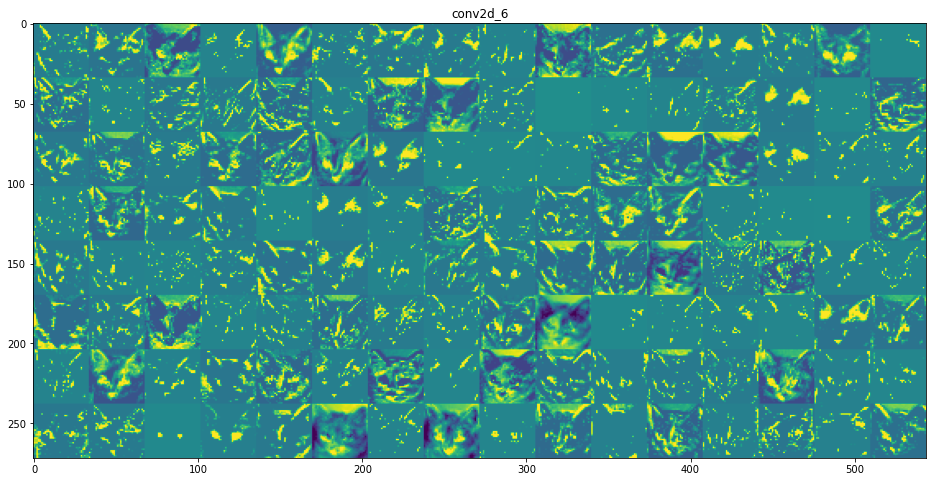

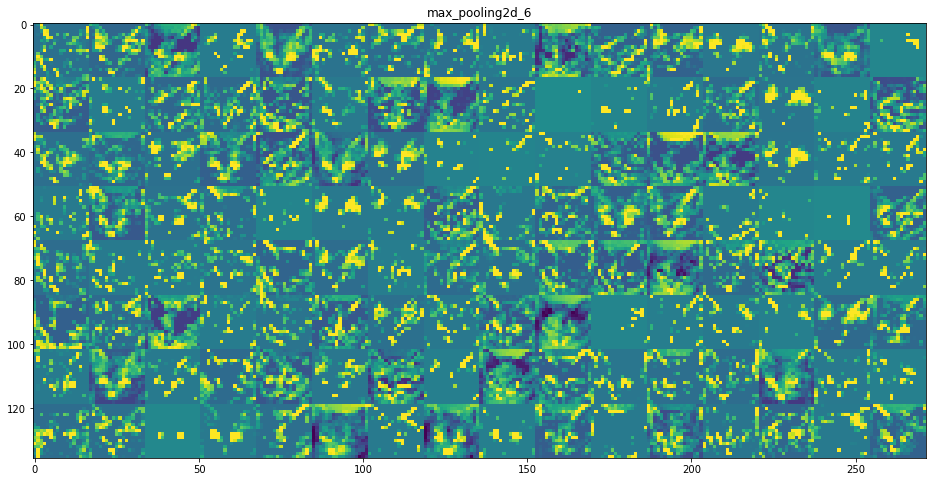

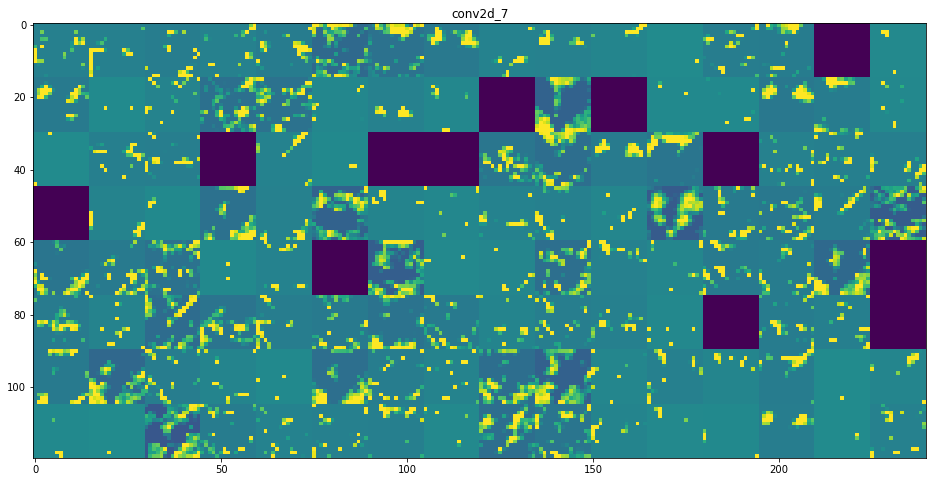

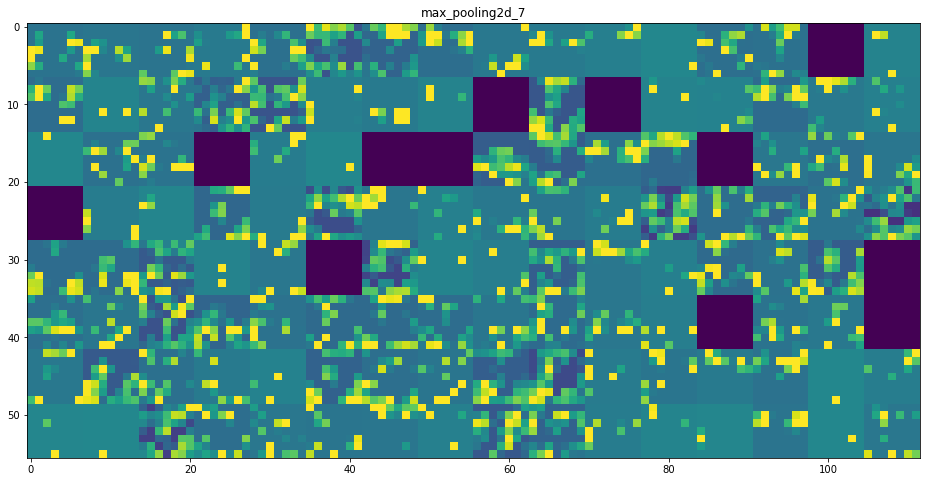

In [28]:
# 층의 이름을 그래프 제목으로 쓰자
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그리기
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵 크기: (1, size, size, n_features)
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기 구하기
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채우기
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성 처리
            # 임의의 실수인 층의 출력 -> 픽셀로 표현 가능한 0~255 사이의 정수로 변환
            channel_image -= channel_image.mean() # 평균 빼고
            channel_image /= channel_image.std() # 표준편차로 나누기
            # 표준 점수 2.0 이내의 값(약 95%)들이 0~255 사이에 놓이도록 증폭
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드 출력
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

### 주목할 점?
*반복적인 변환을 통해 관계없는 정보를 걸러내고 유용한 정보는 강조되고 개선된다.*
#### 1번 층은 초기 사진에 있는 거의 모든 정보가 유지됨

#### 상위 층으로 갈수록 활성화는 점점 **추상적**(시각적으로 이해하기 어려워짐)
* '고양이 귀' , '고양이 눈'처럼 **고수준 개념을 인코딩**하기 시작
* 이미지의 시각적 콘텐츠 정보 감소
* **이미지 클래스**(타깃에 관한 정보)**에 관한 정보 증가** 

#### **비어있는 활성화**가 층이 깊어지면서 증가
* 필터에 인코딩된 패턴이 입력 이미지에 나타나지 않았음을 의미

---

## 2. 컨브넷 필터 시각화하기
각 **필터**가 반응하는 **시각적 패턴** 확인하기

빈 입력 이미지에서 시작해 특정 필터의 응답을 최대화 하기 위해 컨브넷 입력 이미지에 **경사 상승법** 사용!  
-> 결과적으로 선택된 필터가 최대로 응답하는 이미지가 된다.

### 특정 합성곱 층의 한 필터의 값을 최대화하는 손실 텐서 정의하기 
활성화 값을 최대화하기 위해 입력 이미지를 변경하도록 확률적 경사 상승법을 사용\
예를 들어 여기에서는 ImageNet에 사전 훈련된 VGG16 네트워크에서 block3_conv1 층의 필터 0번의 활성화를 손실로 정의:

In [35]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras import backend as K
tf.compat.v1.disable_eager_execution() # disable the eager-execution constrain form tf2 with the compat mode for tf1

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
# loss 함수 정의
loss = K.mean(layer_output[:, :, :, filter_index])

2022-03-23 12:17:48.438490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-23 12:17:48.450910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-23 12:17:48.523891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### 경사 상승법 구현을 위해 모델의 입력에 대한 손실의 그래디언트 구하기
케라스 backend 모듈의 gradients 함수 사용

In [36]:
# gradients 함수가 반환하는 텐서 리스트(여기에서는 크기가 1인 리스트)에서 1번째 텐서를 추출
grads = K.gradients(loss, model.input)[0]

### 그래디언트 정규화하기 (그래디언트 클리핑 기법)
경사 상승법 과정을 부드럽게 하기 위해 그래디언트 텐서를 L2 노름(텐서에 있는 값을 제곱합의 제곱근)으로 나누어 정규화\
입력 이미지에 적용할 수정량의 크기를 항상 일정 범위 안에 놓을 수 있다.

In [37]:
# divide by 0를 방지하기 위해 1e–5을 더하기
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

### 입력 값에 대한 numpy 출력 값 추출
주어진 입력 이미지에 대해 손실 텐서와 그래디언트 텐서를 계산(keras.optimizers 모듈 대신케라스 백엔드 함수를 사용하여 처리)\
```keras.backend.function()``` 입력값을 받아 지정된 출력 텐서를 얻을 수 있는 keras.backend.Function 객체 생성
    
**iterate:** 넘파이 텐서(크기가 1인 텐서의 리스트)를 입력으로 받아 **손실**과 **그래디언트** 두 개의 넘파이 텐서를 반환

In [38]:
iterate = K.function([model.input], [loss, grads])

# test:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

2022-03-23 12:22:01.415466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### 확률적 경사 상승법을 사용해 손실 최대화
파이썬 loop를 만들어 확률적 경사 상승법 구성

In [40]:
# 노이즈가 섞인 회색 이미지로 시작
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# 업데이트할 그래디언트의 크기
step = 1.

# 경사 상승법 40회 실행
for i in range(40):   
    # 손실 & 그래디언트를 계산
    loss_value, grads_value = iterate([input_img_data])
    # 손실을 최대화하는 방향으로 입력 이미지 수정
    input_img_data += grads_value * step

### 텐서를 이미지 형태로 변환는 함수
결과 이미지 텐서는 (1,150,150,3) 크기의 부동 소수 텐서...
출력 가능한 이미지로 변경하기 위해(0~255 사이의 정수로) 후처리

In [41]:
def deprocess_image(x):
    # 텐서의 평균이 0, 표준 편차가 0.1이 되도록 정규화
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # [0, 1]로 클리핑
    x += 0.5
    x = np.clip(x, 0, 1)

    # RGB 배열로 변환
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### 필터 시각화 이미지 만드는 함수
층의 이름과 필터 번호를 입력으로 받는 함수\
**필터 활성화를 최대화하는 패턴을 이미지 텐서로 출력**

In [42]:
def generate_pattern(layer_name, filter_index, size=150):
    # 주어진 층과 필터의 활성화를 최대화하기 위한 손실 함수 정의
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 손실에 대한 입력 이미지의 그래디언트 계산
    grads = K.gradients(loss, model.input)[0]

    # 그래디언트 정규화
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 입력 이미지에 대한 손실과 그래디언트를 반환
    iterate = K.function([model.input], [loss, grads])
    
    # 잡음이 섞인 회색 이미지로 시작
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 경사 상승법을 40 단계 실행
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

2022-03-23 12:32:50.533370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


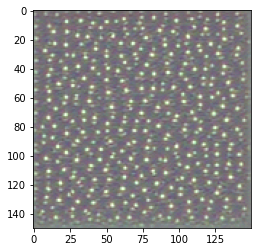

In [43]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()